# Satellite Image Classification


[Dataset on Kaggle](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

Import the necessary libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.layers import Rescaling, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import os
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns

## Dataset loading and split

In [7]:
def retrieveDataset(dataset_path="./data", seed=42):
    image_size = (256, 256)
    batch_size = 64

    # Step 1: Get all image file paths and labels
    all_image_paths = []
    all_labels = []
    class_names = sorted(os.listdir(dataset_path))  # Ensure consistent order
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                all_image_paths.append(os.path.join(class_dir, fname))
                all_labels.append(class_indices[class_name])

    # Step 2: Stratified split into train, val, test (80%, 10%, 10%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=seed
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed
    )

    def paths_to_dataset(paths, labels):
        path_ds = tf.data.Dataset.from_tensor_slices(paths)
        label_ds = tf.data.Dataset.from_tensor_slices(tf.keras.utils.to_categorical(labels, num_classes=len(class_names)))
    
        def _decode_and_resize(filepath):
            image = tf.io.read_file(filepath)
            image = tf.image.decode_image(image, channels=3, expand_animations=False)
            image.set_shape([None, None, 3])  # Required to fix shape issue
            return tf.image.resize(image, image_size)
    
        image_ds = path_ds.map(_decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
        return tf.data.Dataset.zip((image_ds, label_ds)).batch(batch_size)

    train_dataset = paths_to_dataset(X_train, y_train)
    validation_dataset = paths_to_dataset(X_val, y_val)
    test_dataset = paths_to_dataset(X_test, y_test)

    def count_classes(dataset):
        counts = np.zeros(len(class_names), dtype=int)
        for images, labels in dataset:
            counts += np.sum(labels.numpy().astype(int), axis=0)
        return counts

    train_counts = count_classes(train_dataset)
    val_counts = count_classes(validation_dataset)
    test_counts = count_classes(test_dataset)

    print("Class distribution in training set:")
    for class_name, count in zip(class_names, train_counts):
        print(f"{class_name}: {count}")

    print("Class distribution in validation set:")
    for class_name, count in zip(class_names, val_counts):
        print(f"{class_name}: {count}")

    print("Class distribution in test set:")
    for class_name, count in zip(class_names, test_counts):
        print(f"{class_name}: {count}")

    # Step 3: Balance the training dataset
    max_count = np.max(train_counts)
    balanced_images = []
    balanced_labels = []

    class_data = {i: [] for i in range(len(class_names))}

    for images, labels in train_dataset.unbatch():
        label_index = np.argmax(labels.numpy())
        class_data[label_index].append((images, labels))

    for i, data in class_data.items():
        repeat_count = max_count // len(data)
        remainder = max_count % len(data)
        for _ in range(repeat_count):
            balanced_images.extend([img for img, _ in data])
            balanced_labels.extend([lbl for _, lbl in data])
        balanced_images.extend([img for img, _ in data[:remainder]])
        balanced_labels.extend([lbl for _, lbl in data[:remainder]])

    balanced_data = list(zip(balanced_images, balanced_labels))
    np.random.shuffle(balanced_data)
    balanced_images, balanced_labels = zip(*balanced_data)

    balanced_train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.stack(balanced_images), tf.stack(balanced_labels))
    ).batch(batch_size)

    balanced_train_counts = count_classes(balanced_train_dataset)

    print("Class distribution in balanced training set:")
    for class_name, count in zip(class_names, balanced_train_counts):
        print(f"{class_name}: {count}")

    return balanced_train_dataset, validation_dataset, test_dataset, train_counts, val_counts, test_counts, balanced_train_counts, class_names


In [8]:
balanced_train, validation_set, test_set, train_counts, val_counts, test_counts, balanced_train_counts, class_names = retrieveDataset()

2025-04-16 19:22:49.557797: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-16 19:22:49.640461: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in training set:
cloudy: 1200
desert: 904
green_area: 1200
water: 1200
Class distribution in validation set:
cloudy: 150
desert: 113
green_area: 150
water: 150
Class distribution in test set:
cloudy: 150
desert: 114
green_area: 150
water: 150


2025-04-16 19:22:50.853607: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in balanced training set:
cloudy: 1200
desert: 1200
green_area: 1200
water: 1200


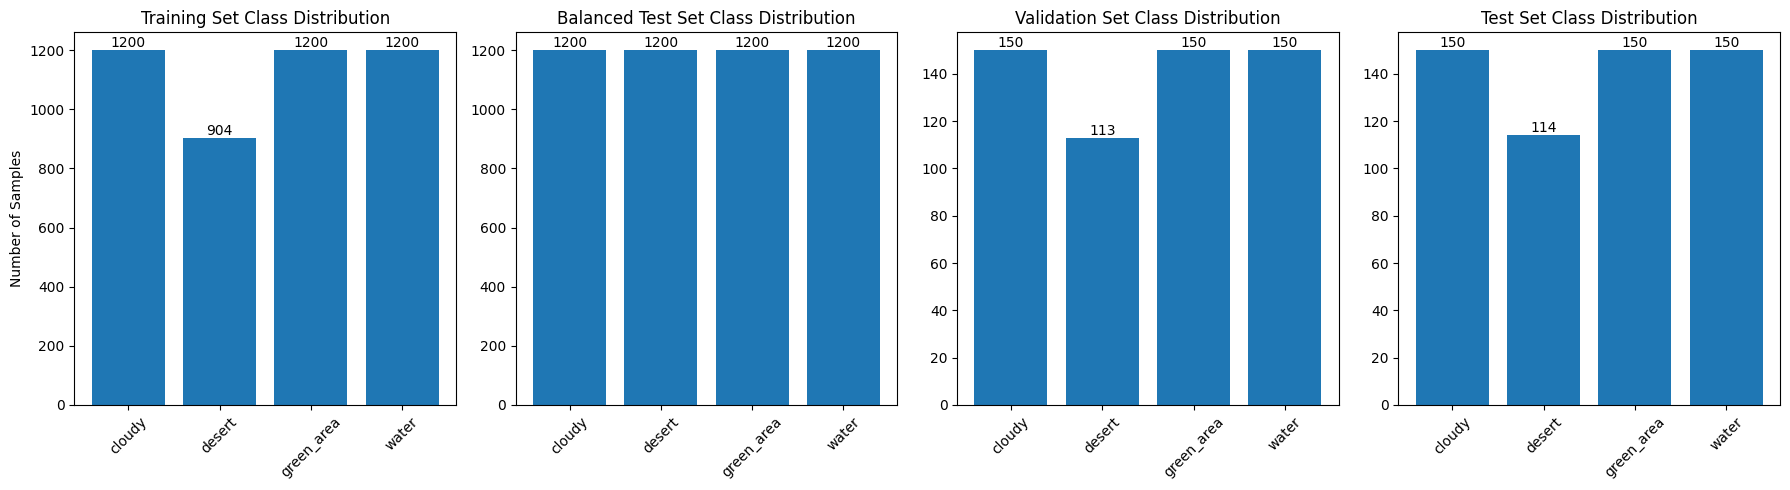

In [9]:
def plot_class_distribution(train_counts, val_counts, test_counts, balanced_train_counts, class_names):
    plt.figure(figsize=(18, 5))
    
    # Training set
    plt.subplot(1, 4, 1)
    bars = plt.bar(class_names, train_counts)
    plt.title('Training Set Class Distribution')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')


    # Balanced train set
    plt.subplot(1, 4, 2)
    bars = plt.bar(class_names, balanced_train_counts)
    plt.title('Balanced Test Set Class Distribution')
    plt.xticks(rotation=45)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

    
    # Validation set
    plt.subplot(1, 4, 3)
    bars = plt.bar(class_names, val_counts)
    plt.title('Validation Set Class Distribution')
    plt.xticks(rotation=45)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')
    
    # Test set
    plt.subplot(1, 4, 4)
    bars = plt.bar(class_names, test_counts)
    plt.title('Test Set Class Distribution')
    plt.xticks(rotation=45)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')



    
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts, val_counts, test_counts, balanced_train_counts, class_names)

## Data visualization

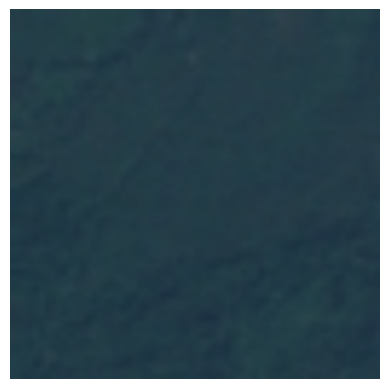

In [72]:
for images, labels in balanced_train.take(1):
    sample_image = images[2].numpy().astype("uint8")  # Convert the first image to a numpy array
    plt.imshow(sample_image)
    plt.axis('off')
    plt.show()

# Baseline 1: Random selection

Random Classifier F1 Score: 0.26


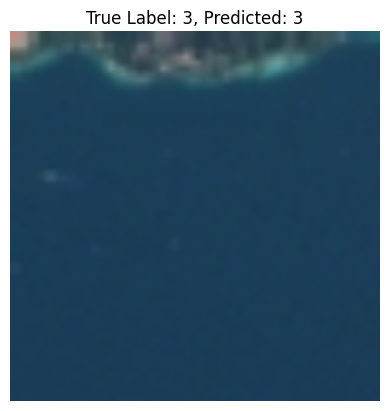

In [15]:
# Collect all images and labels
all_images = []
all_labels = []
for images, labels in validation_set:
    all_images.append(images)
    all_labels.append(labels)

# Convert to numpy arrays
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

# Get the number of classes
num_classes = all_labels.shape[1]

# Generate random predictions
random_predictions = np.random.randint(0, num_classes, size=(all_labels.shape[0]))

# Convert one-hot encoded true labels to class indices
true_labels = np.argmax(all_labels, axis=1)

# Calculate the F1 score (macro average for multiple classes)
f1 = f1_score(true_labels, random_predictions, average='macro')

print(f"Random Classifier F1 Score: {f1:.2f}")

# Display a random image and its true and predicted label
random_index = np.random.randint(0, len(all_images))
plt.imshow(all_images[random_index].astype("uint8"))
plt.axis('off')
plt.title(f"True Label: {true_labels[random_index]}, Predicted: {random_predictions[random_index]}")
plt.show()

# Baseline 2: Neural Network

In [19]:
nn_model = Sequential([
    Rescaling(1./255, input_shape=(256, 256, 3)),

    Flatten(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(4, activation='softmax')
])

nn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,349,892 (192.07 MB)

 Trainable params: 50,349,252 (192.07 MB)

 Non-trainable params: 640 (2.50 KB)

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True 
)

nn_history = nn_model.fit(balanced_train, validation_data=validation_set, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.6820 - loss: 0.7037 - val_accuracy: 0.3606 - val_loss: 2.9070
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.7991 - loss: 0.5385 - val_accuracy: 0.6377 - val_loss: 0.9123
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.7942 - loss: 0.5385 - val_accuracy: 0.5488 - val_loss: 0.7450
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.8147 - loss: 0.5368 - val_accuracy: 0.6039 - val_loss: 1.0058
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.8115 - loss: 0.5248 - val_accuracy: 0.5062 - val_loss: 1.0183
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.8109 - loss: 0.5210 - val_accuracy: 0.5417 - val_loss: 0.9115
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.8208 - loss: 0.5102 - val_accuracy: 0.6803 - val_loss: 0.6793
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.8197 - loss: 0.5003 - val_accu

In [21]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    
    # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

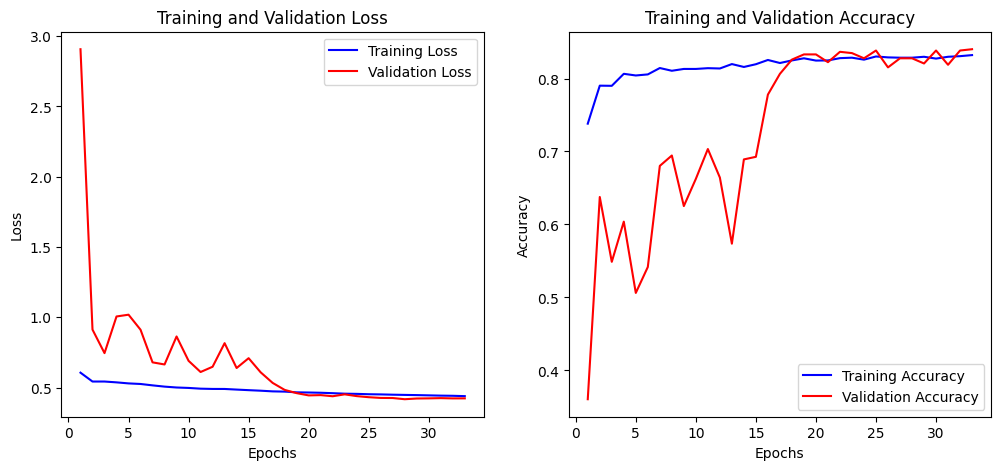

In [22]:
plot_training_history(nn_history)

In [25]:
def plot_confusion_matrix_4_classes(model, dataset, class_names):
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


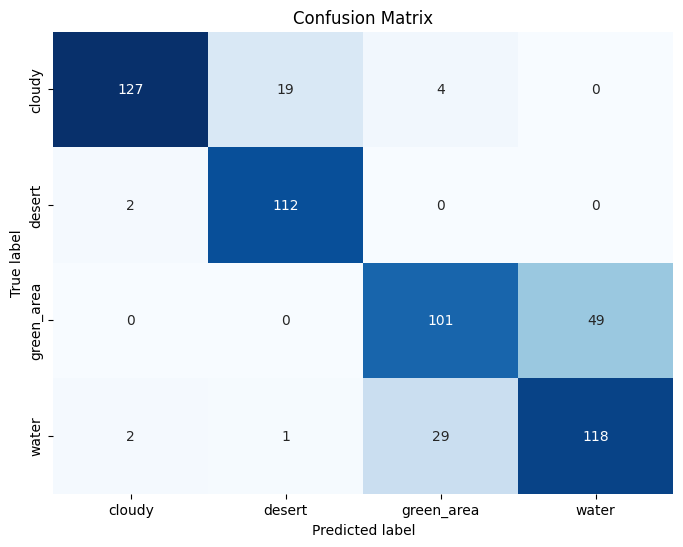

In [27]:
plot_confusion_matrix_4_classes(nn_model, test_set, class_names)

In [31]:
def evaluate_model(model, validation_dataset, class_names):
    y_true = []
    y_pred = []
    
    for images, labels in validation_dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    f1_per_class = f1_score(y_true, y_pred, average=None)
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"F1 Score Macro: {f1_macro:.2f}")
    for idx, label in enumerate(class_names):
        print(f"F1 Score for {label}: {f1_per_class[idx]:.2f}")

In [32]:
evaluate_model(nn_model, test_set, class_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
F1 Score Macro: 0.82
F1 Score for cloudy: 0.90
F1 Score for desert: 0.91
F1 Score for green_area: 0.71
F1 Score for water: 0.74


In [34]:
nn_model.save('trained_nn_model.keras')

# Convolutional Neural Network

In [ ]:
# LOAD MODEL
cnn_model = tf.keras.models.load_model('trained_cnn_model_14_epochs.keras')
model.summary()

In [43]:
cnn_model = Sequential([
    Rescaling(1./255, input_shape=(256, 256, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(256, activation='relu'),
    BatchNormalization(),


    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(4, activation='softmax')
])

cnn_model.name = "CNN_Sat"

# Compilazione del modello
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()


Model: "CNN_Sat"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,516 (1.25 MB)

 Trainable params: 326,276 (1.24 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [44]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,          
    restore_best_weights=True,
    start_from_epoch=5,
)

# Training
history = cnn_model.fit(balanced_train, validation_data=validation_set, epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8067 - loss: 0.5159 - val_accuracy: 0.4867 - val_loss: 1.3417
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 654ms/step - accuracy: 0.9113 - loss: 0.2324 - val_accuracy: 0.5240 - val_loss: 1.5021
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 670ms/step - accuracy: 0.9232 - loss: 0.2024 - val_accuracy: 0.5027 - val_loss: 1.8446
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 692ms/step - accuracy: 0.9294 - loss: 0.1890 - val_accuracy: 0.4583 - val_loss: 2.0870
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 739ms/step - accuracy: 0.9312 - loss: 0.1843 - val_accuracy: 0.5009 - val_loss: 2.0418
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 661ms/step - accuracy: 0.9344 - loss: 0.1738 - val_accuracy: 0.6110 - val_loss: 1.6900
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 654ms/step - accuracy: 0.9394 - loss: 0.1666 - val_accuracy: 0.7353 - val_loss: 1.5295
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 662ms/step - accuracy: 0.9429 - loss: 0.1578 - 

In [45]:
cnn_model.save('trained_cnn_model_99acc.keras')

In [47]:
evaluate_model(cnn_model, test_set, class_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
F1 Score Macro: 0.99
F1 Score for cloudy: 1.00
F1 Score for desert: 1.00
F1 Score for green_area: 0.98
F1 Score for water: 0.98


In [50]:
from collections import defaultdict

def show_inference_example(model, dataset, class_names):
    for images, labels in dataset.shuffle(1000).take(1):
        predictions = model.predict(images)
        class_indices = defaultdict(list)
        
        for i in range(len(images)):
            true_label = np.argmax(labels[i].numpy())
            class_indices[true_label].append(i)

        selected_indices = []
        classes = list(class_indices.keys())
        np.random.shuffle(classes)

        while len(selected_indices) < 12 and classes:
            for class_idx in classes.copy():
                if class_indices[class_idx]:
                    selected_indices.append(class_indices[class_idx].pop())
                    if len(selected_indices) == 12:
                        break
                else:
                    classes.remove(class_idx)

        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(selected_indices[:12]):
            image = images[idx].numpy().astype("uint8")
            true_label = class_names[np.argmax(labels[idx])]
            pred_label = class_names[np.argmax(predictions[idx])]
            
            plt.subplot(2, 6, i+1)
            plt.imshow(image)
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


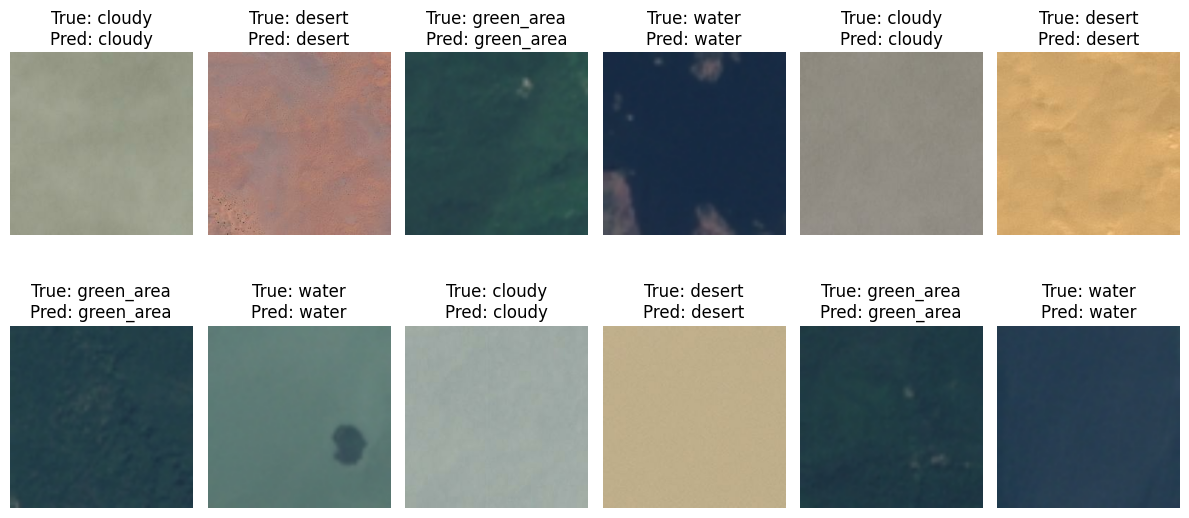

2025-04-16 20:48:34.416762: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
show_inference_example(cnn_model, test_set, class_names)

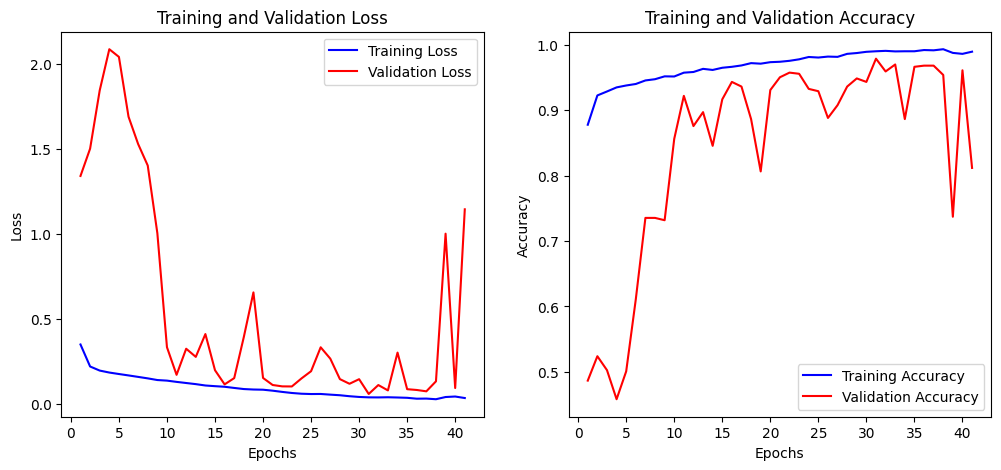

In [53]:
plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


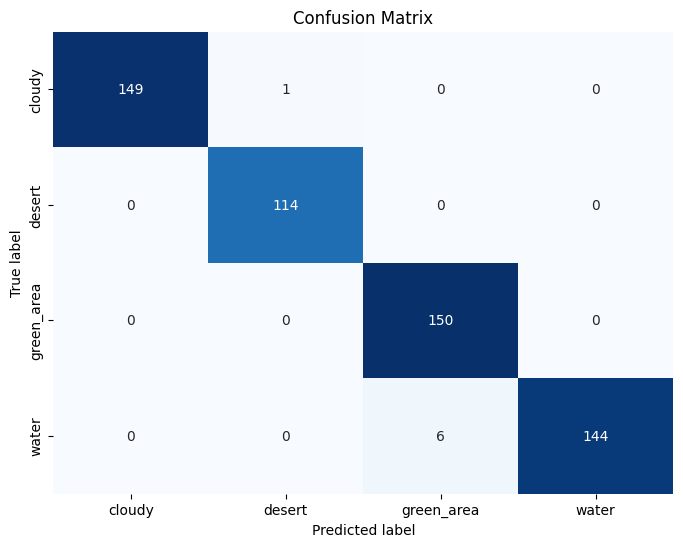

In [55]:
plot_confusion_matrix_4_classes(cnn_model, test_set, class_names)

# Random Forest

In [58]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels


def filter_classes(images, labels, max_class=4):
    mask = labels < max_class
    return images[mask], labels[mask]

In [63]:
train_images, train_labels = dataset_to_numpy(balanced_train)
val_images, val_labels = dataset_to_numpy(validation_set)
test_images, test_labels = dataset_to_numpy(test_set)

train_images = train_images.reshape(train_images.shape[0], -1)
val_images = val_images.reshape(val_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Convert one-hot encoded labels to class indices
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)


train_images, train_labels = filter_classes(train_images, train_labels)
val_images, val_labels = filter_classes(val_images, val_labels)
test_images, test_labels = filter_classes(test_images, test_labels)

print("Train distribution:", np.bincount(train_labels))
print("Val distribution:", np.bincount(val_labels))
print("Test distribution:", np.bincount(test_labels))

Train distribution: [1200 1200 1200 1200]
Val distribution: [150 113 150 150]
Test distribution: [150 114 150 150]


In [64]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_images, train_labels)

predictions = rf_classifier.predict(test_images)

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, predictions))

print("\nClassification Report:")
print(classification_report(test_labels, predictions))


Confusion Matrix:
[[147   1   1   1]
 [  5 109   0   0]
 [  0   0 143   7]
 [  2   0  12 136]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       150
           1       0.99      0.96      0.97       114
           2       0.92      0.95      0.93       150
           3       0.94      0.91      0.93       150

    accuracy                           0.95       564
   macro avg       0.95      0.95      0.95       564
weighted avg       0.95      0.95      0.95       564



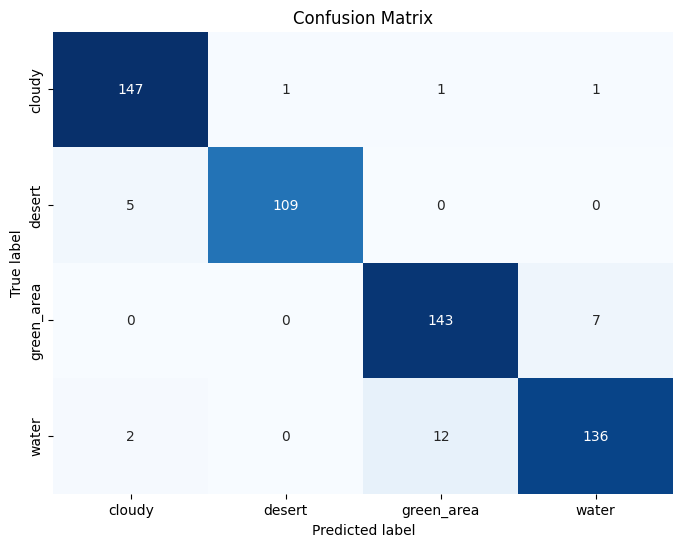

In [68]:
def plot_confusion_matrix_4_classes(model, dataset, class_names):
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        images = images.numpy().reshape(images.shape[0], -1)
        predictions = model.predict(images)
        y_pred.extend(predictions) 
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix_4_classes(rf_classifier, test_set, class_names)

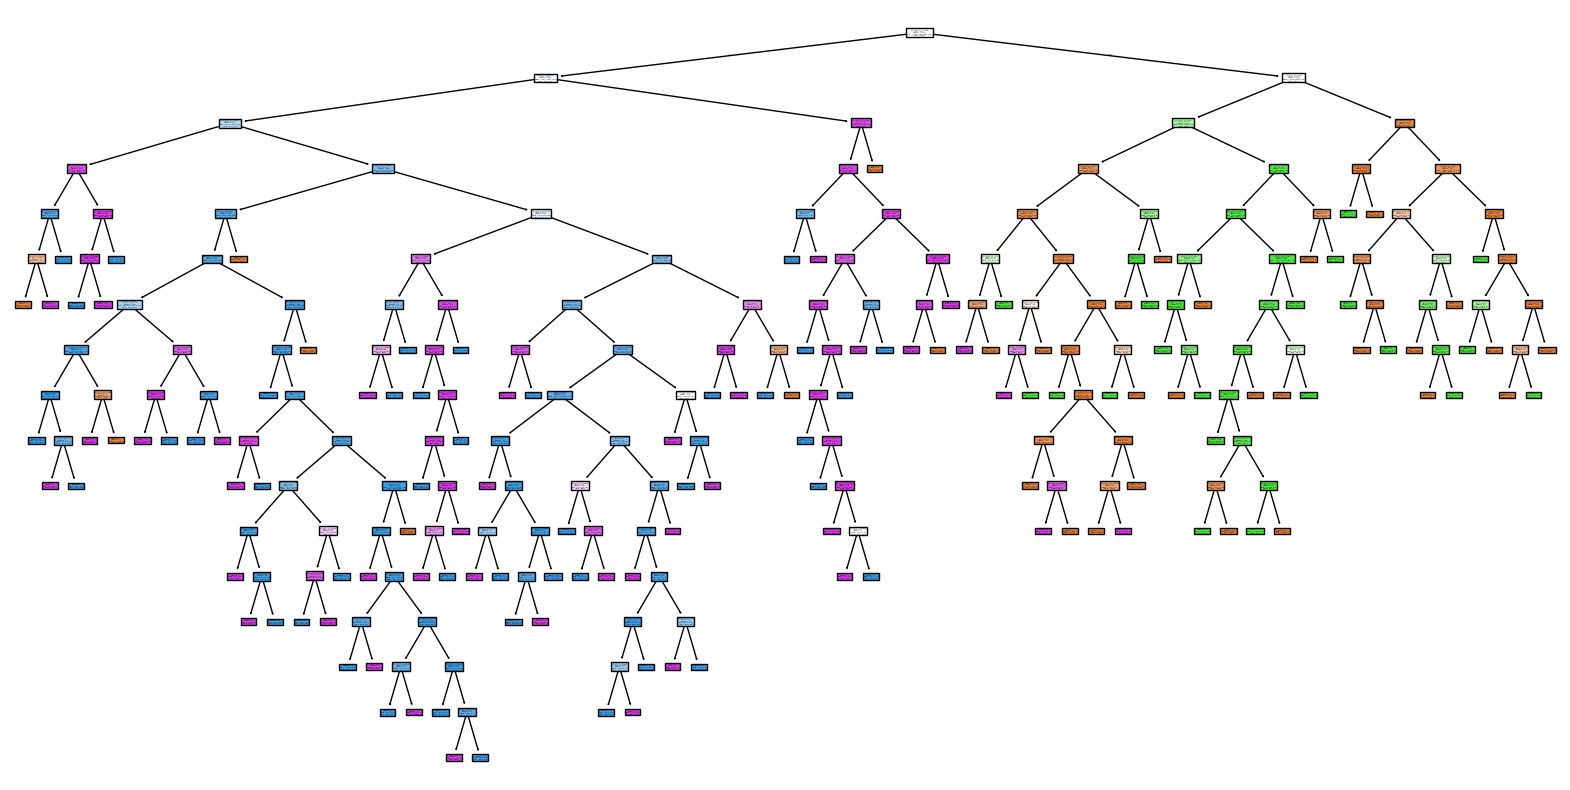

In [70]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], feature_names=None, class_names=class_names, filled=True)
plt.savefig("random_forest_tree.pdf")
plt.show()